# CNN visualization

The convolutional neural networks (CNNs) may act as a black-box model which provides accurate predictions for images but it is really hard to understand why that particular decision was made. To understand the underlying decision mechanisms a bit more we can turn to visualization techniques.

For our example we will use VGG16 neural network. We will save and explore the activations after the 3rd and 4th convolutional blocks.

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png">
Credits: https://neurohive.io/en/popular-networks/vgg16/

At the end of the 3rd convolutional block we have
 - 56 x 56 x 256 neurons
 
This means that we have 256 convolutional filters, and each was evaluated 56 x 56 times. Neurons in each layer has a given receptive field (the number of pixels on the original image that can affect the actual neuron). The receptive field size depends on the convolutional layers and maxpools. For example a convolutional layer with kernel size of 3 and stride 1 has a receptive field of 3, because each neuron collected information from a 3x3 region of the image.
 
 
### Red dots: neurons, blue square: receptive field

Let's see how we can get the field of view for each neuron in a given layer:
<img src='https://patbaa.web.elte.hu/neurons_on_img.png'>
 
 
In this notebook we will save the 3rd and 4th convolutional blocks' results for 10.000 images and select the top 5-10 images which activated the given convolutional filter the most. We will visualize these images and crop them to check the field of view for the given neuron.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### We need to subtract the RGB means and convert it to BGR

In [3]:
def preprocess(img, RGB=True):
    '''
    For RGB images (PIL) use RGB=True
    For BGR images (cv2) use RGB=False
    '''
    img  = np.array(img.resize((224, 224))).astype(float)
    if RGB:
        img = img[...,::-1]
    img -= [103.939, 116.779, 123.68]
    
    return img[None, ...] # to form a batch with batch_size of 1

In [4]:
model = VGG16(include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000)

W0225 13:56:25.128448 140621300926208 deprecation.py:506] From /usr/local/miniconda3/envs/cuda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Modify the VGG16 model to output the result of given convolutional layers too, not just the predictions!

In [5]:
# 2nd block sees 14x14px
# 5th block sees 196x196pixels
b3c3_out    = model.get_layer('block3_conv3').output
b4c3_out    = model.get_layer('block4_conv3').output
predictions = model.get_layer('predictions').output

model_vis = Model(model.input, [b3c3_out, b4c3_out, predictions])

In [6]:
imagenet_images = list(Path('imagenet_data/images/').glob('*JPEG'))
len(imagenet_images)

1281097

Generate activation maps for 25.000 random imagenet images!

In [7]:
np.random.seed(137)
np.random.shuffle(imagenet_images)

In [8]:
%%time
N = 25000
b3 = np.empty((N, 56, 56, 256))
b4 = np.empty((N, 28, 28, 512))

for idx, i in enumerate(imagenet_images[:N]):
    # we have a few grayscale images
    img = Image.open(i).convert('RGB')
    img = preprocess(img)
    b3_tmp, b4_tmp, _ = model_vis.predict(img)
    
    # [0] to select the element from the batch
    b3[idx,] = b3_tmp[0]
    b4[idx,] = b4_tmp[0]

CPU times: user 12h 44min 30s, sys: 29min 24s, total: 13h 13min 55s
Wall time: 1h 18min 19s


In [9]:
np.save('b3', b3)
np.save('b4', b4)

In [10]:
b3 = np.load('b3.npy')
b4 = np.load('b4.npy')

In [11]:
# that excites the neuron
# thats all info the given neuron has seen
# maxpooling is not fully correct
def get_patch(block_num, i, j):
    rec_field = {3:40, 4:92}[block_num]
    n_neurons = {3:56, 4:28}[block_num]
    
    x_mid = i*224/(n_neurons+1)
    y_mid = j*224/(n_neurons+1)
    
    x_min = int(max(x_mid - rec_field/2,0))
    x_max = int(min(x_mid + rec_field/2,223))
    y_min = int(max(y_mid - rec_field/2,0))
    y_max = int(min(y_mid + rec_field/2,223))
    
    return x_min, x_max, y_min, y_max

In [12]:
def plot_topN(block_num, filter_num, N, cropped=False):
    if block_num == 3:
        b = b3
        n_neurons = 56
        
    if block_num == 4:
        b = b4
        n_neurons = 28
        
    plt.figure(figsize=(4*N, 4))    
    for idx, k in enumerate(b[...,filter_num].max(-1).max(-1).argsort()[-N:]):
        i, j = np.unravel_index(b[k,:,:,filter_num].argmax(), (n_neurons, n_neurons))
        img = np.array(Image.open(imagenet_images[k]).resize((224, 224)))
        plt.subplot(1, N, idx+1)
        plt.axis('off')
        
        if not cropped:
            plt.imshow(Image.fromarray(img))
        else:
            x_min, x_max, y_min, y_max = get_patch(block_num, i, j)
            #print(x_min, x_max, y_min, y_max)
            plt.imshow(Image.fromarray(img[x_min:x_max, y_min:y_max]))
        
    plt.show()

## A few examples from the 3rd block

# What is common?

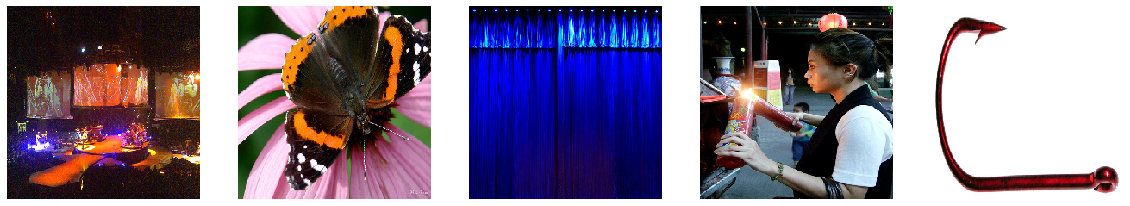

In [13]:
plot_topN(block_num=3, filter_num=44, N=5, cropped=False)

<p style="margin-bottom:15cm;"></p>

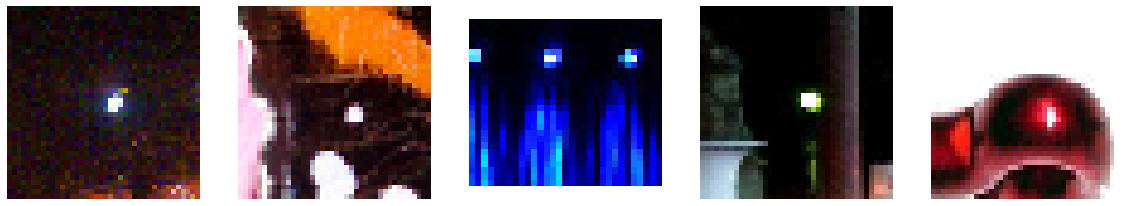

In [14]:
plot_topN(block_num=3, filter_num=44, N=5, cropped=True)

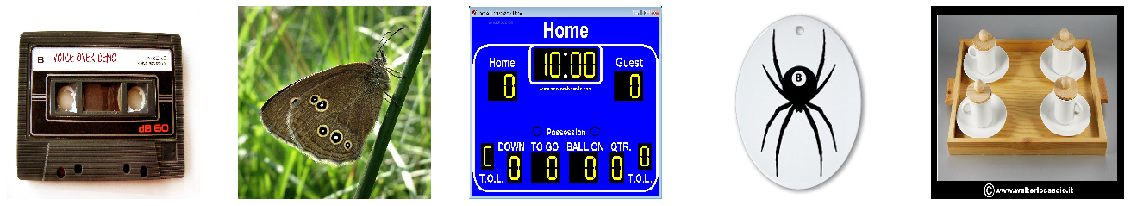

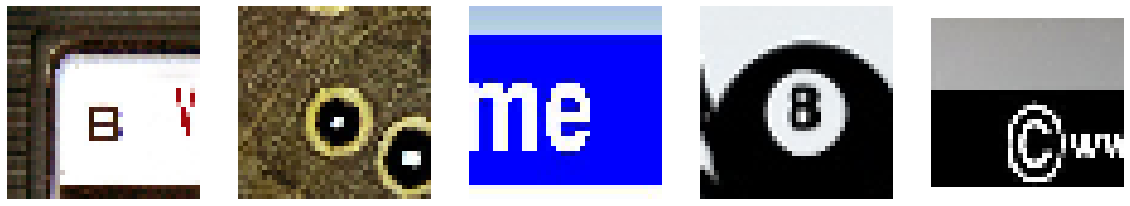

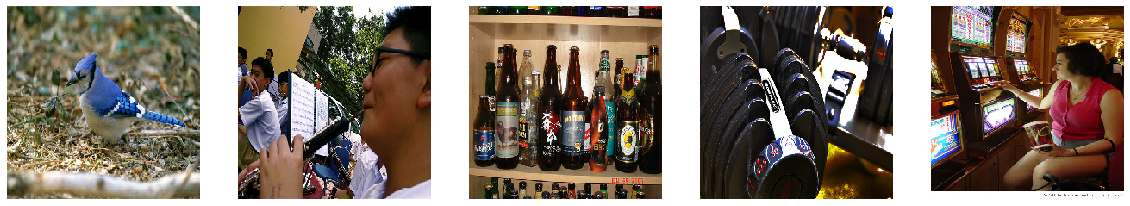

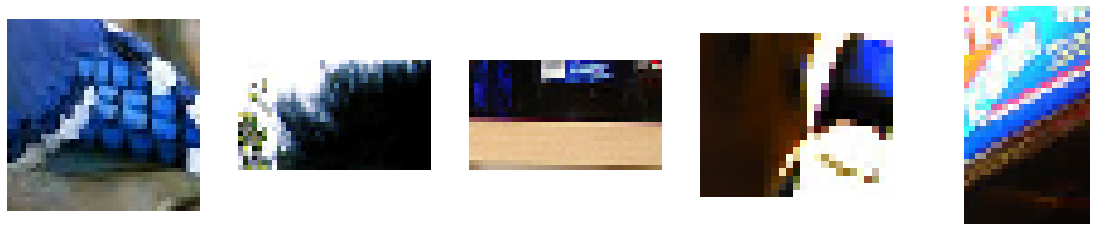

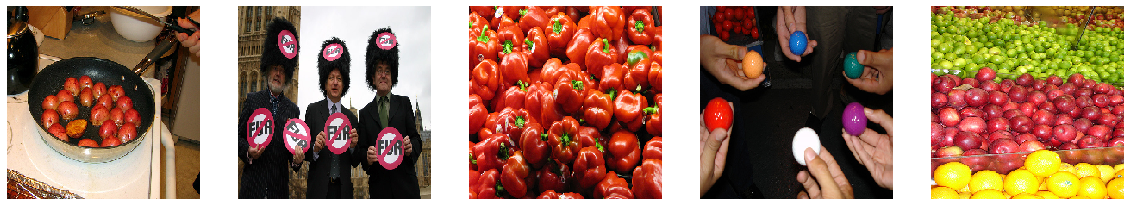

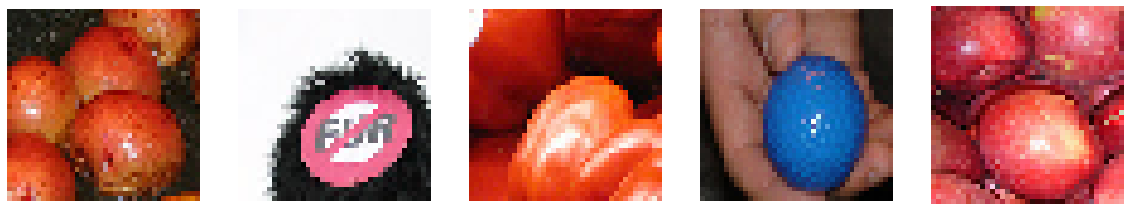

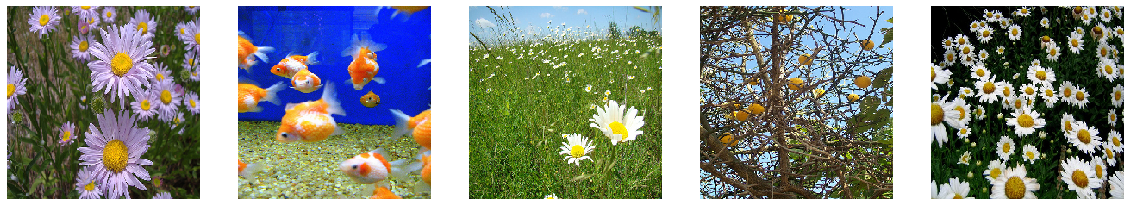

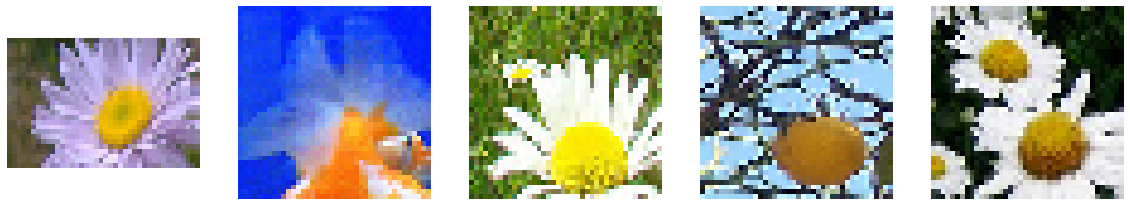

In [15]:
N=5
plot_topN(block_num=3, filter_num=20, N=5, cropped=False)
plot_topN(block_num=3, filter_num=20, N=5, cropped=True)
print()
plot_topN(block_num=3, filter_num=41, N=5, cropped=False)
plot_topN(block_num=3, filter_num=41, N=5, cropped=True)
print()
plot_topN(block_num=3, filter_num=50, N=5, cropped=False)
plot_topN(block_num=3, filter_num=50, N=5, cropped=True)
print()
plot_topN(block_num=3, filter_num=96, N=5, cropped=False)
plot_topN(block_num=3, filter_num=96, N=5, cropped=True)

## A few examples from the 4th block

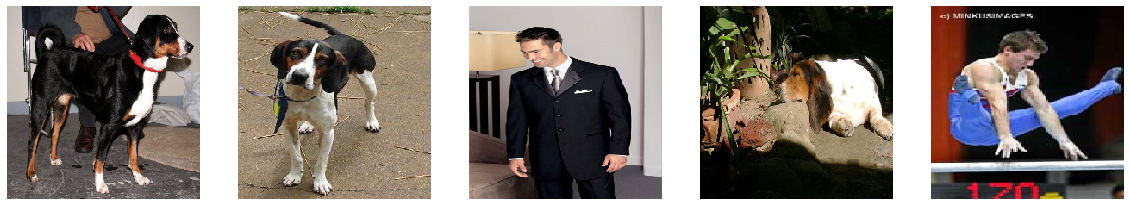

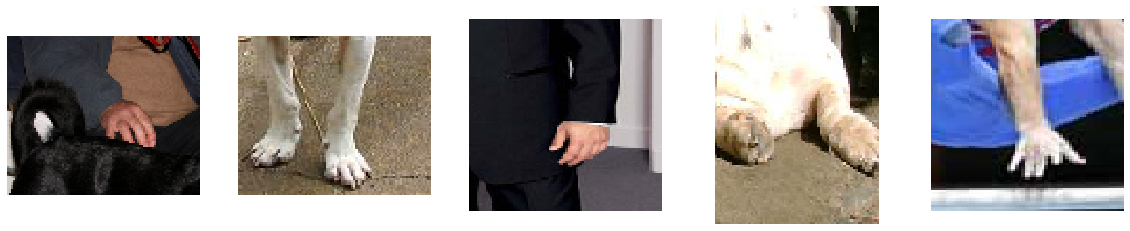

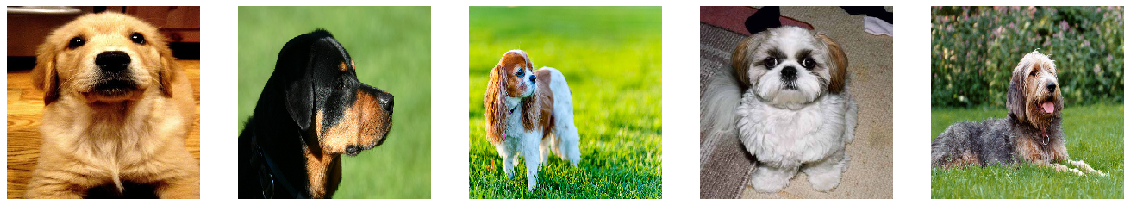

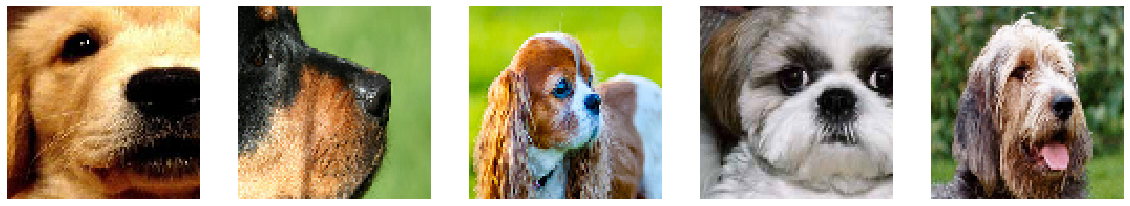

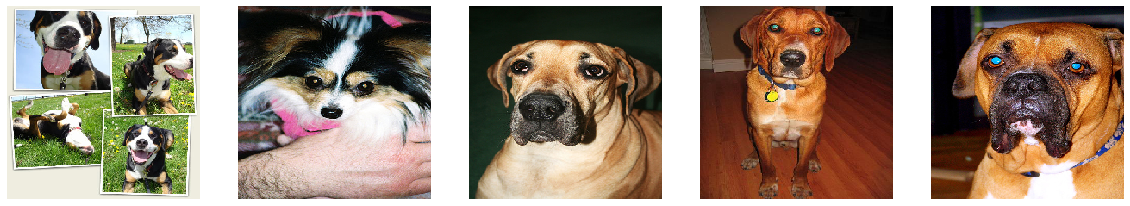

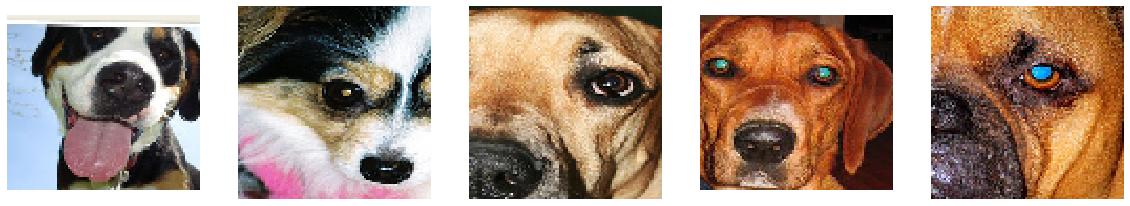

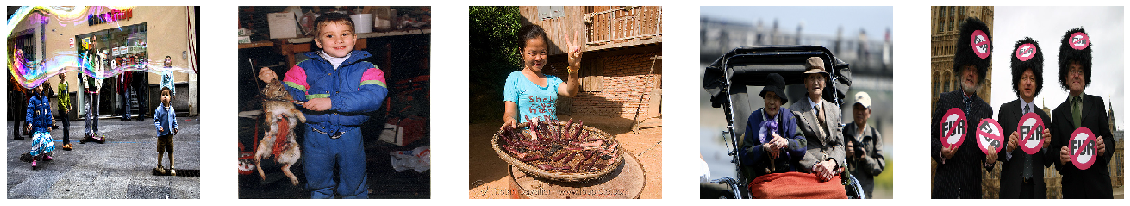

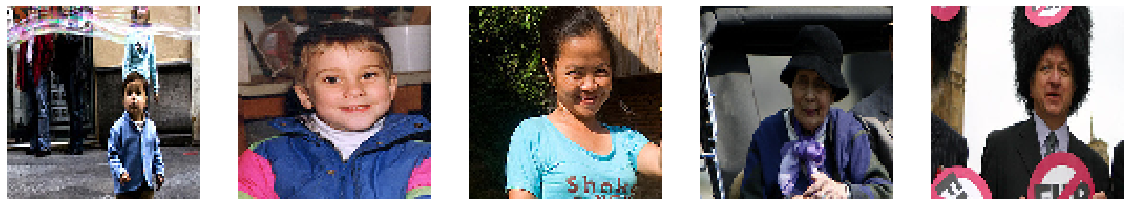

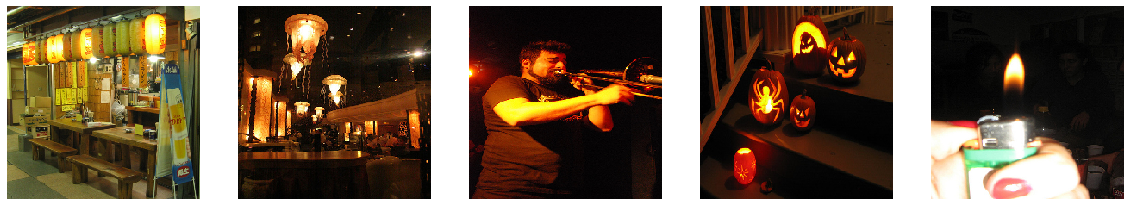

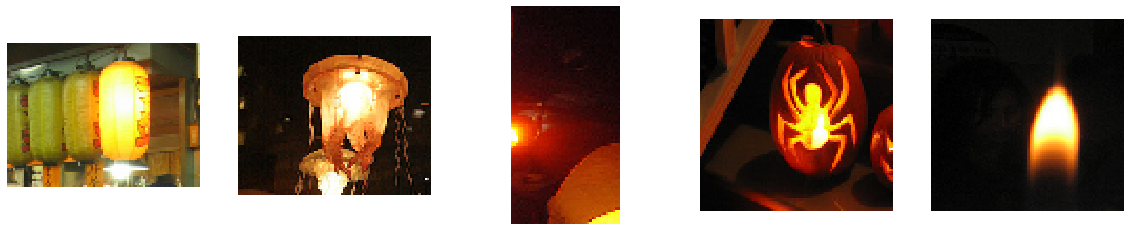

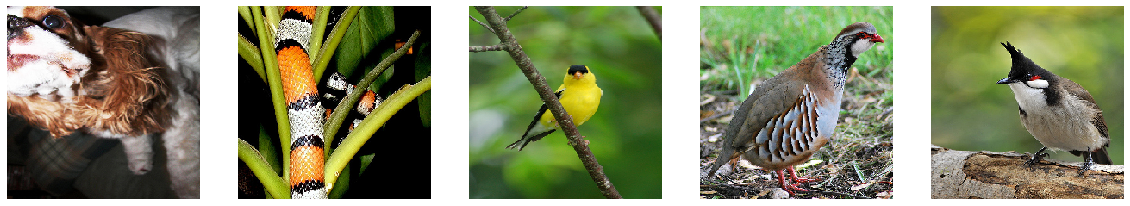

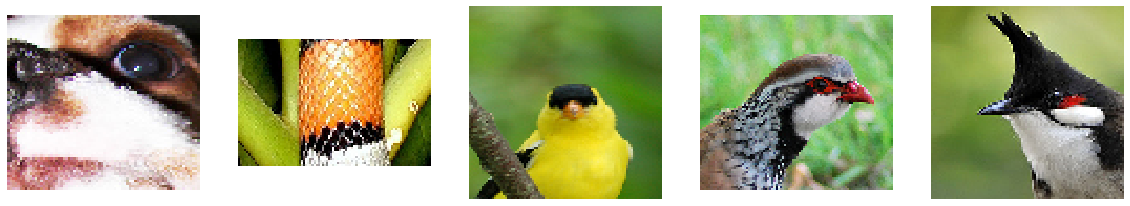

In [16]:
N=5
plot_topN(block_num=4, filter_num=3, N=5, cropped=False)
plot_topN(block_num=4, filter_num=3, N=5, cropped=True)
print()
plot_topN(block_num=4, filter_num=13, N=5, cropped=False)
plot_topN(block_num=4, filter_num=13, N=5, cropped=True)
print()
plot_topN(block_num=4, filter_num=18, N=5, cropped=False)
plot_topN(block_num=4, filter_num=18, N=5, cropped=True)
print()
plot_topN(block_num=4, filter_num=53, N=5, cropped=False)
plot_topN(block_num=4, filter_num=53, N=5, cropped=True)
print()
plot_topN(block_num=4, filter_num=64, N=5, cropped=False)
plot_topN(block_num=4, filter_num=64, N=5, cropped=True)
print()
plot_topN(block_num=4, filter_num=81, N=5, cropped=False)
plot_topN(block_num=4, filter_num=81, N=5, cropped=True)
print()